## Import libraries


In [1]:
# %pip install "segment-geospatial[samgeo3]"

In [1]:
import os
from glob import glob

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pyproj
import rasterio as rio
from pyproj import Transformer
from rasterio.transform import rowcol
from samgeo import SamGeo3

# from huggingface_hub import login
# login()

data_dir = "/beegfs/halder/GITHUB/RESEARCH/WBCrop/data"

## Define the data path


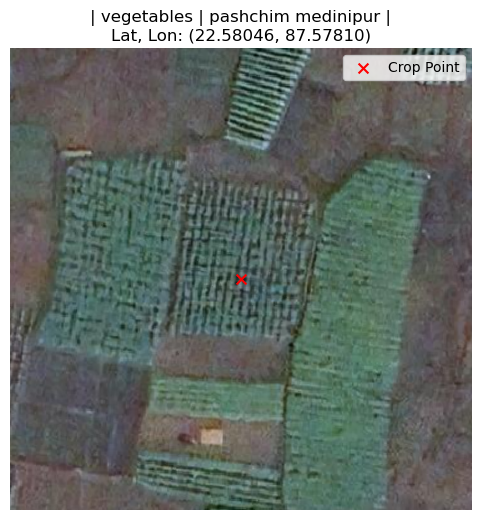

In [55]:
# Read the point shapefile
crop_samples_gdf = gpd.read_file(
    os.path.join(data_dir, "processed", "wbcrop_points.gpkg")
)

# Read the image paths
image_paths = glob(
    os.path.join(data_dir, "raw", "high_res_patches", "high_res_patches", "*.tif")
)
# image_path = np.random.choice(image_paths)
image_path = image_paths[1100]
image_id = int(os.path.basename(image_path).split("_")[0])
point_info = crop_samples_gdf.loc[crop_samples_gdf["id"] == image_id].iloc[0]
crop, district = point_info["crop"], point_info["district"]
lat, lon = float(point_info["latitude"]), float(point_info["longitude"])

with rio.open(image_path, "r") as src:
    rgb = src.read([1, 2, 3])
    rgb = np.transpose(rgb, (1, 2, 0))
    meta = src.meta
    transform = src.transform

transformer = Transformer.from_crs("EPSG:4326", src.crs, always_xy=True)
x_proj, y_proj = transformer.transform(lon, lat)
row, col = rowcol(transform, x_proj, y_proj)

plt.figure(figsize=(6, 6))
plt.imshow(rgb)
plt.scatter(col, row, color="red", s=50, marker="x", label="Crop Point")
plt.legend()
plt.title(f"| {crop} | {district} |\nLat, Lon: ({lat:.5f}, {lon:.5f})")
plt.axis("off")
plt.show()

## Initialize SAM3


In [ ]:
sam3 = SamGeo3(
    backend="meta",
    device="cuda",
    checkpoint_path=None,
    load_from_HF=True,
    enable_inst_interactivity=True,
)

Using cuda device and meta backend


## Set the image


In [56]:
sam3.set_image(image_path)

## Generate mask with point prompt


Found one object.


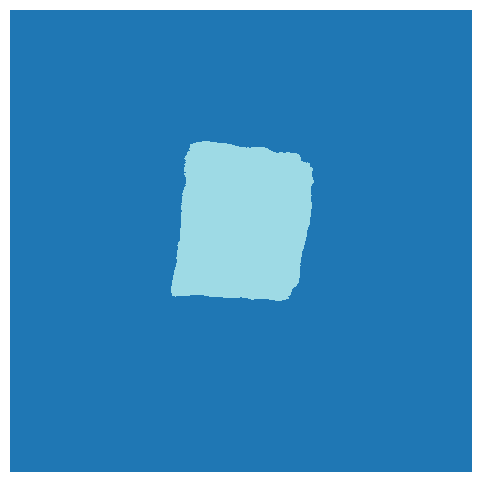

In [62]:
row = int(row)
col = int(col)
point_coords = np.array([[col, row]])

masks = sam3.generate_masks_by_points(point_coords, min_size=100)

sam3.show_masks(figsize=(6, 6))

## Save the mask


In [ ]:
# sam3.save_masks(output="field_masks_binary.tif", unique=False)

Saved 1 mask(s) to field_masks_binary.tif


## Build the algorithm


In [ ]:
import os
from glob import glob

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pyproj
import rasterio as rio
from pyproj import Transformer
from rasterio.transform import rowcol
from samgeo import SamGeo3
from tqdm import tqdm


def generate_field_mask(image_dir, point_path, out_dir):

    os.makedirs(out_dir, exist_ok=True)

    # Read the point shapefile
    crop_samples_gdf = gpd.read_file(point_path)

    # Read the image paths
    image_paths = glob(os.path.join(image_dir, "*.tif"))

    # Initialize SAM3
    sam3 = SamGeo3(
        backend="meta",
        device="cuda",
        checkpoint_path=None,
        load_from_HF=True,
        enable_inst_interactivity=True,
    )

    # Iterate over the images
    for path in tqdm(image_paths):
        image_path = path
        basename = os.path.basename(image_path)
        image_id = int(basename.split("_")[0])
        point_info = crop_samples_gdf.loc[crop_samples_gdf["id"] == image_id].iloc[0]
        lat, lon = float(point_info["latitude"]), float(point_info["longitude"])

        # Read the image
        with rio.open(image_path, "r") as src:
            rgb = src.read([1, 2, 3])
            rgb = np.transpose(rgb, (1, 2, 0))
            meta = src.meta
            transform = src.transform

        transformer = Transformer.from_crs("EPSG:4326", src.crs, always_xy=True)
        x_proj, y_proj = transformer.transform(lon, lat)
        row, col = rowcol(transform, x_proj, y_proj)

        # Set the image
        sam3.set_image(image_path)

        # Define point coordinates
        row = int(row)
        col = int(col)
        point_coords = np.array([[col, row]])

        # Apply segmentation
        sam3.generate_masks_by_points(point_coords, min_size=100)

        # Save the output
        out_path = os.path.join(out_dir, basename)
        print("Mask saved at path:", out_path)


if __name__ == "__main__":

    data_dir = "/beegfs/halder/GITHUB/RESEARCH/WBCrop/data"
    image_dir = os.path.join(
        "raw",
        "high_res_patches",
        "high_res_patches",
    )
    point_path = os.path.join(data_dir, "processed", "wbcrop_points.gpkg")

    out_dir = os.path.join(data_dir, "raw", "high_res_masks")

    generate_field_mask(image_dir, point_path, out_dir)